#**Mountain Car Project**
### Team members:
#### Amal Fawzy     ID:20399126
#### Eman Elrefai   ID:20104066
#### Hanan Omara    ID:20398559

> ### The Mountain Car

> This section will demonstrate how **Q-Learning** and **DQN** can create a solution to the mountain car gym environment. The Mountain car is an environment where a car must climb a mountain. Because gravity is stronger than the car's engine, it cannot merely accelerate up the steep slope even with full throttle. The vehicle is situated in a valley and must learn to utilize potential energy by driving up the opposite hill before the car can make it to the goal at the top of the rightmost hill.

# **1- We will start warking with DQN in two different Methodologies**

> # Deep Q-Network

> The  [DQN algorithm](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) was developed by DeepMind in 2015. It was able to solve a wide range of Atari games (some to superhuman level) by combining reinforcement learning and deep neural networks at scale. The algorithm was developed by enhancing a classic RL algorithm called Q-Learning with deep neural networks and a technique called *experience replay*.

> ### DQN algorithm

> Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

> Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

> The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

> \begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

> However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.








### **Required installation and Import Libiraries**

In [ ]:
!pip install pyautogui

In [ ]:
!pip install stable-baselines3


In [ ]:
# remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
! apt-get install -y swig cmake libglfw3-dev
! apt-get install -y xvfb x11-utils libgl1-mesa-glx libglfw3
! pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# Create a new virtual environment
!python -m venv myenv
!source myenv/bin/activate

# Install required system dependencies
!apt-get update
!apt-get install -y xvfb x11-utils

# Install required Python dependencies
!pip install pyvirtualdisplay==0.2.*
!pip install PyOpenGL==3.1.*
!pip install PyOpenGL-accelerate==3.1.*
!pip install gym[box2d]==0.17.*

# Install aptitude
!sudo apt-get install aptitude

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglfw3-dev is already the newest version (3.3.2-1).
swig is already the newest version (4.0.1-5build1).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
libglfw3 is already the newest version (3.3.2-1).
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Error: Command '['/content/myenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: myenv/bin/activate: No such file or directory
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http

In [ ]:
# Original code (with modifications for video recording)
import numpy as np
import pylab
import collections
from collections import deque
import sys
import gym
import pylab
import matplotlib.pyplot as plt
from collections import deque
from keras.models import model_from_json
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU
from keras.initializers import he_normal, RandomNormal
from tensorflow.keras.optimizers import SGD
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import seaborn as sns
import pyvirtualdisplay
import math
import pickle as pkl
from gym.envs.registration import registry, register, make


# **First Methodology using `DQN Learning`**

## **Trial 1:**

- The neural network model in Trial 1 has two hidden layers with 48 and 64 units respectively, both using LeakyReLU activation.
- The learning rate is set to 0.0001, and the optimizer used is Adam.
- The discount factor is 0.95, and the epsilon value starts at 1 and decays exponentially over time.
- The maximum size of the agent's memory is set to 2000.
- The agent uses experience replay by randomly sampling a minibatch from memory for training.
- The target model is updated periodically to match the current model's weights.
- The agent uses the epsilon-greedy policy for exploration, with a random action taken with probability epsilon.
- The agent trains the model using the mean squared error loss.

## **Build Agent(Car) Function**

In [ ]:
class MountainCarAgent():
    def __init__(self, action_size, state_size, discount_factor, learning_rate,
                 epsilon, epsilon_decay, epsilon_min):

        # parameters
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = 1
        self.load_model = True
        self.epsilon_min = epsilon_min
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        # action and state sizes
        self.action_size = action_size
        self.state_size = state_size

        # build the NN model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        initializer = he_normal(seed=1000)
        model = Sequential()
        model.add(Dense(48, input_dim=2, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(64, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.action_size, activation=LeakyReLU(alpha=0.1), kernel_initializer=initializer))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0001))
        return model

    def get_action(self, state):
        if random.uniform(0, 1) <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train_model(self):
        if len(self.memory) > self.batch_size:
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.target_model.predict(update_output)
            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:  # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0, validation_split=0.1)

    def save_model_weights(self, name):
        self.model.save_weights(name)

# Get environment
env = gym.make('MountainCar-v0')
env.reset()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_episodes = 40



## **Train Function**

In [ ]:
def train_agent(agent, nam, rewards_per_episode, for_steps, episodes, ep_re, ep_st, update_counter, epsilon):
    rewards_per_episode_10 = []
    steps_per_episode_10 = []

    for episode in range(n_episodes):
        done = False
        score = 0
        state = env.reset()
        steps = 0

        while not done:
            env.render()
            agent.epsilon = 0.01 + (1 - 0.01) * np.exp(-0.001 * update_counter)
            update_counter += 1

            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            reward = 100 * ((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) -
                            (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
            if next_state[0] >= 0.5:
                reward += 1

            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()

            state = next_state
            steps += 1
            score += reward

            if done:
                agent.update_target_model()

        for_steps.append(steps)
        rewards_per_episode.append(score)
        episodes.append(episode)

        if score == np.max(rewards_per_episode):
            ep_re = episode
        if steps == np.min(for_steps):
            ep_st = episode

        if episode % 10 == 0:
            rewards_per_episode_10.append(np.mean(rewards_per_episode[-10:]))
            steps_per_episode_10.append(np.mean(for_steps[-10:]))

        print("Episode {0}, Reward {1}, Memory Length {2}, Number of Steps {3}, Epsilon {4}".format(
            episode, score, len(agent.memory), steps, agent.epsilon))

        if np.mean(rewards_per_episode[-5:]) > 1.5:
            break

        if episode > 1 and episode % 5 == 0:
            agent.save_model_weights(name=nam)

    # Plot Cumulative Reward per Episode (Every 10 Episodes)
    plt.plot(range(0, len(rewards_per_episode_10) * 10, 10), rewards_per_episode_10)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward per Episode (Every 10 Episodes)")
    plt.grid(True)
    plt.show()

    # Plot Number of Timesteps per Episode (Every 10 Episodes)
    plt.plot(range(0, len(steps_per_episode_10) * 10, 10), steps_per_episode_10)
    plt.xlabel("Episode")
    plt.ylabel("Number of Timesteps")
    plt.title("Number of Timesteps per Episode (Every 10 Episodes)")
    plt.grid(True)
    plt.show()

    return rewards_per_episode, for_steps, ep_re, ep_st


## **Trial 1 with discount_factor=0.95 and learning_rate=0.02**

1/1 [==============================] - 0s 13ms/step
Episode 0, Reward -0.005152722073725136, Memory Length 200, Number of Steps 200, Epsilon 0.8213543943995963
1/1 [==============================] - 0s 14ms/step
Episode 1, Reward -0.0011804615909963463, Memory Length 400, Number of Steps 200, Epsilon 0.6742807943399114
1/1 [==============================] - 0s 14ms/step
Episode 2, Reward -0.00816220983858541, Memory Length 600, Number of Steps 200, Epsilon 0.5538671150051557
1/1 [==============================] - 0s 14ms/step
Episode 3, Reward 0.00038514702477968933, Memory Length 800, Number of Steps 200, Epsilon 0.4552807326425205
1/1 [==============================] - 0s 16ms/step
Episode 4, Reward -0.012888037291972942, Memory Length 1000, Number of Steps 200, Epsilon 0.3745650295675263
1/1 [==============================] - 0s 13ms/step
Episode 5, Reward 0.0011334929225136504, Memory Length 1200, Number of Steps 200, Epsilon 0.3084806012037175
1/1 [==============================] 

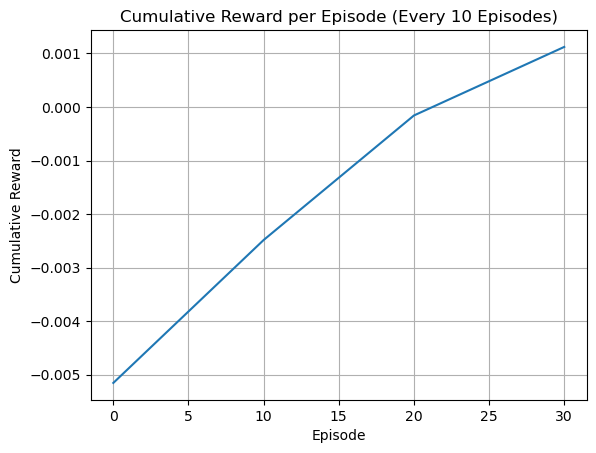

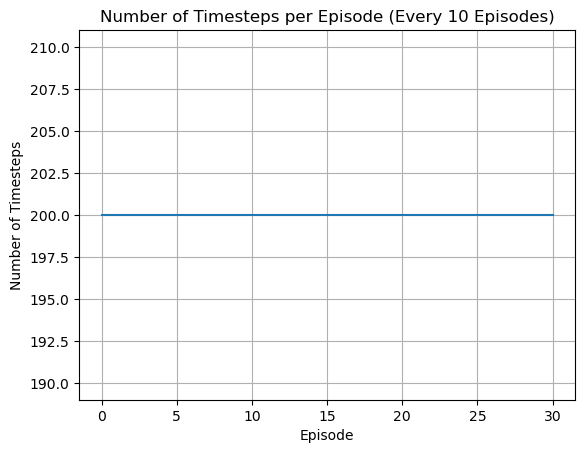

In [ ]:
# Trial 1
agent_1 = MountainCarAgent(action_size, state_size, discount_factor=0.95, learning_rate=0.02,
                           epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)
rewards_per_episode_1, steps_per_episode_1, ep_re1_1, ep_st1_1 = train_agent(
    agent_1,
    nam="model_weights_1.h5",
    rewards_per_episode=[],
    for_steps=[],
    episodes=[],
    ep_re=0,
    ep_st=0,
    update_counter=0,
    epsilon=1
)

re_episode_trial1=np.array(rewards_per_episode_1).max()
ste1=np.array(steps_per_episode_1).min()



##  **Report the training performance for trial 1**
 1. cumulative reward per episode obtained by the agent.
 2. the number of time-steps required to solve the task per episode of experience.

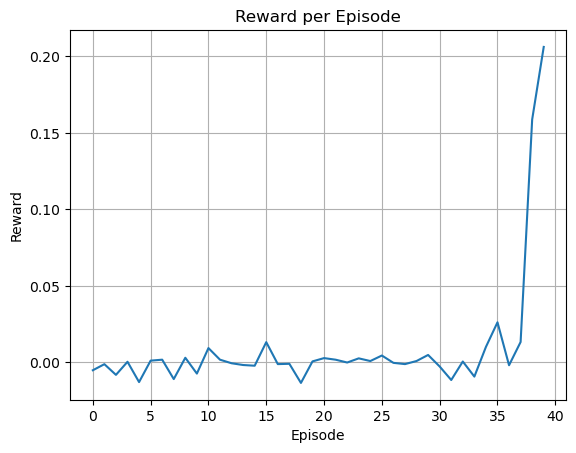

Average reward of last 100 episodes (mean) is 0.009302214962241226


In [ ]:
average_reward_last_100 = np.mean(rewards_per_episode_1[-100:])
pylab.plot(range(len(rewards_per_episode_1)), rewards_per_episode_1)
pylab.xlabel("Episode")
pylab.ylabel("Reward")
pylab.title("Reward per Episode")
pylab.grid(True)
pylab.show()

print("Average reward of last 100 episodes (mean) is", average_reward_last_100)


Average reward of last 100 episodes is 200.0


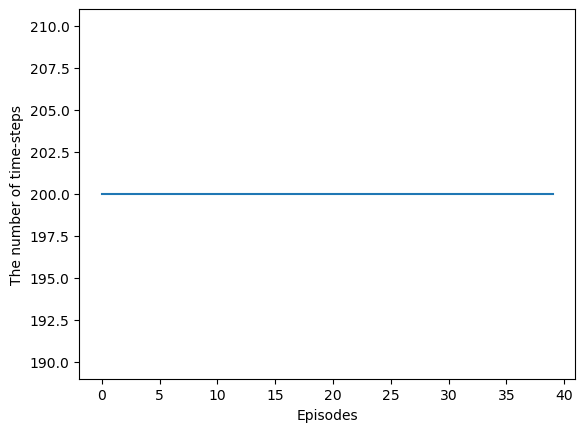

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.mean(steps_per_episode_1[-100:])))
plt.plot(list(range(len(steps_per_episode_1))), steps_per_episode_1)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()


## **Trial 2:**

- The neural network model in Trial 2 has three hidden layers with 64, 128, and 64 units respectively, all using LeakyReLU activation.
- The learning rate is set to 0.0005, and the optimizer used is Adam.
- The discount factor is 0.99, and the epsilon value starts at 1 and decays exponentially over time.
- The maximum size of the agent's memory is set to 2000.
- The agent uses experience replay by randomly sampling a minibatch from memory for training.
- The target model is updated periodically to match the current model's weights.
- The agent uses the epsilon-greedy policy for exploration, with a random action taken with probability epsilon.
- The agent trains the model using the mean squared error loss.

## **Build Agent(Car) Function**

In [1]:
class MountainCarAgent():
    def _init_(self, action_size, state_size, discount_factor, learning_rate,
                 epsilon, epsilon_decay, epsilon_min):

        # parameters
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = 1
        self.load_model = True
        self.epsilon_min = epsilon_min
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        # action and state sizes
        self.action_size = action_size
        self.state_size = state_size

        # build the NN model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        initializer = he_normal(seed=1000)
        model = Sequential()
        model.add(Dense(64, input_dim=2, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(128, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(64, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.action_size, activation=LeakyReLU(alpha=0.1), kernel_initializer=initializer))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))
        return model

    def get_action(self, state):
        if random.uniform(0, 1) <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train_model(self):
        if len(self.memory) > self.batch_size:
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.target_model.predict(update_output)
            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:  # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0, validation_split=0.1)

    def save_model_weights(self, name):
        self.model.save_weights(name)

## **Get environment**

In [ ]:
# Get environment
env = gym.make('MountainCar-v0')
env.reset()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_episodes = 40

## **Train Function**

In [ ]:
def train_agent(agent, nam, rewards_per_episode, for_steps, episodes, ep_re, ep_st, update_counter, epsilon):
    for episode in range(n_episodes):
        done = False
        score = 0
        # reset at the start of each episode
        state = env.reset()
        steps = 0
        while not done:
            env.render()
            agent.epsilon = 0.01 + (1 - 0.01) * np.exp(-0.001 * update_counter)
            update_counter = update_counter + 1
            # get action for the current state and take a step in the environment
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            reward = 100 * ((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) -
                            (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
            if next_state[0] >= 0.5:
                reward += 1
            agent.append_sample(state, action, reward, next_state, done)

            # train after each step
            agent.train_model()

            # add reward to the total score of this episode and number of steps
            state = next_state
            steps += 1
            score += reward
            if done:
                agent.update_target_model()

        # store total reward obtained in this episode
        for_steps.append(steps)
        rewards_per_episode.append(score)
        episodes.append(episode)
        if score == np.max(rewards_per_episode):
            ep_re = episode
        if steps == np.min(for_steps):
            ep_st = episode
        # every episode:
        print("episode {0}, reward {1}, memory_length {2}, Number of Steps {3}, epsilon {4}".format(
            episode, score, len(agent.memory), steps, agent.epsilon))
        # terminate if no major learning for previous 5 episodes
        if np.mean(rewards_per_episode[-5:]) > 1.5:
            break
        # every few episodes:
        if episode > 1 and episode % 5 == 0:
            # save model weights
            agent.save_model_weights(name=nam)

    return rewards_per_episode, for_steps, ep_re, ep_st

## **Trial_2 DQN with discount=0.99, lr=0.001**

In [ ]:
#trial_2

agent_2= MountainCarAgent(action_size, state_size, discount_factor=0.99, learning_rate=0.001,
                         epsilon=1, epsilon_decay=0.995, epsilon_min=0.01)
rewards_per_episode_2, steps_per_episode_2, ep_re2, ep_st2 = train_agent(
    agent_2,
    nam="model_weights_2.h5",
    rewards_per_episode=[],
    for_steps=[],
    episodes=[],
    ep_re=0,
    ep_st=0,
    update_counter=0,
    epsilon=1
)

re_episode_trial2=np.array(rewards_per_episode_2).max()
ste2=np.array(steps_per_episode_2).min()



1/1 [==============================] - 0s 14ms/step
episode 0, reward -0.0029377777407902945, memory_length 200, Number of Steps 200, epsilon 0.8213543943995963
1/1 [==============================] - 0s 12ms/step
episode 1, reward 0.01191278536746871, memory_length 400, Number of Steps 200, epsilon 0.6742807943399114
1/1 [==============================] - 0s 14ms/step
episode 2, reward 0.05272159246391404, memory_length 600, Number of Steps 200, epsilon 0.5538671150051557
1/1 [==============================] - 0s 16ms/step
episode 3, reward 0.08292362501595159, memory_length 800, Number of Steps 200, epsilon 0.4552807326425205
1/1 [==============================] - 0s 14ms/step
episode 4, reward 1.4991073300227589, memory_length 986, Number of Steps 186, epsilon 0.3797048346672943
1/1 [==============================] - 0s 14ms/step
episode 5, reward 0.039071896872652036, memory_length 1186, Number of Steps 200, epsilon 0.31268871770372464
1/1 [==============================] - 0s 14ms/

##  **Report the training performance for trial 2**
 1. cumulative reward per episode obtained by the agent.
 2. the number of time-steps required to solve the task per episode of experience.

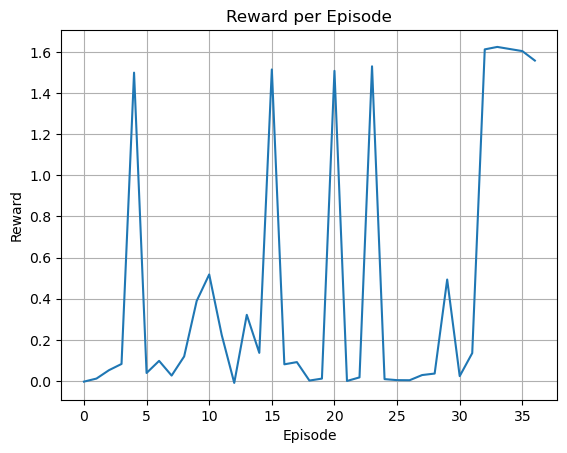

In [ ]:
average_reward_last_100 = np.mean(rewards_per_episode_2[-100:])
pylab.plot(range(len(rewards_per_episode_2)), rewards_per_episode_2)
pylab.xlabel("Episode")
pylab.ylabel("Reward")
pylab.title("Reward per Episode")
pylab.grid(True)
pylab.show()


Average reward of last 100 episodes (mean) is 0.45976042647984444
Average reward of last 100 episodes is 188.51351351351352


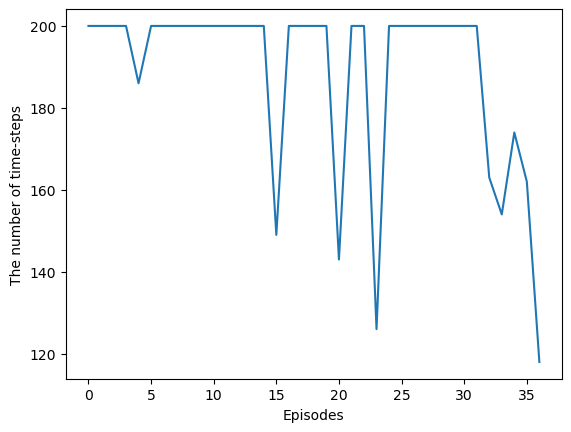

In [ ]:
print("Average reward of last 100 episodes (mean) is", average_reward_last_100)
print("Average reward of last 100 episodes is {0}".format(np.mean(steps_per_episode_2[-100:])))
plt.plot(list(range(len(steps_per_episode_2))), steps_per_episode_2)
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

## **Compare performance of the Two trials**

**Comparison:**

1. Trial 2 has a deeper neural network with an additional hidden layer compared to Trial 1.
2.  Trial 2 has a higher learning rate (0.0005) compared to Trial 1 (0.0001).
3. Trial 2 has a higher discount factor (0.99) compared to Trial 1 (0.95).
4. Trial 2 has a slower epsilon decay rate (0.995) compared to Trial 1 (0.99).
5. Trial 2 has a lower epsilon minimum value (0.01) compared to Trial 1 (0.02).
6. The rewards_per_episode and steps_per_episode metrics can be used to compare the performance of the two trials.
7. The maximum reward obtained in Trial 1 is re_episode_trial1, while the maximum reward obtained in Trial 2 is re_episode_trial2.
8. The minimum number of steps taken in Trial 1 is ste1, and in Trial 2 is ste2.

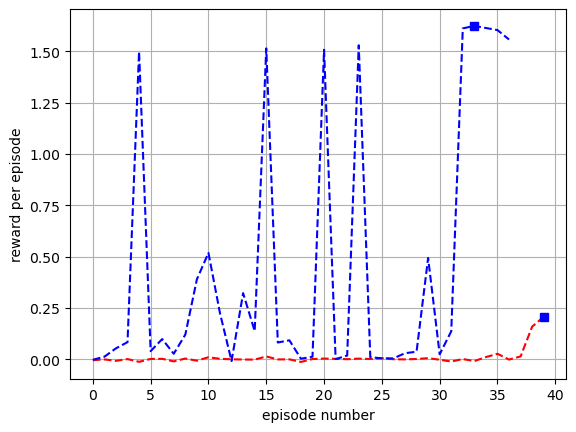

In [ ]:
# plot the performance
plt.plot(list(range(len(rewards_per_episode_1))), rewards_per_episode_1, 'r--',ep_re1_1, re_episode_trial1, 'bs',label='gamma=0.95,alpha=0.02,epsilon_decay=0.99')
plt.plot(list(range(len(rewards_per_episode_2))), rewards_per_episode_2, 'b--', ep_re2, re_episode_trial2, 'bs',label='gamma=0.8,alpha=0.005,epsilon_decay=0.99')
# plt.legend()
plt.grid()
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

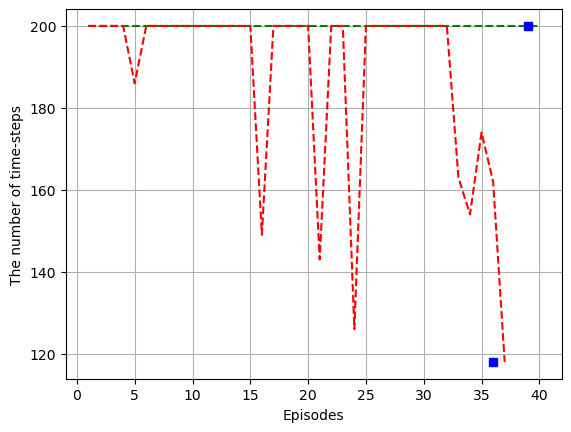

In [ ]:
plt.plot(np.arange(1, len(steps_per_episode_1)+1), steps_per_episode_1, 'g--', ep_st1_1,ste1, 'bs',label='gamma=0.95,alpha=0.02,epsilon_decay=0.99')
plt.plot(np.arange(1, len(steps_per_episode_2)+1), steps_per_episode_2, 'r--', ep_st2,ste2, 'bs',label='gamma=0.8,alpha=0.005,epsilon_decay=0.99')
plt.grid()
# plt.legend()
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

### **Observations with respect to the results obtained**
  When comparing the average rewards of the last 100 episodes (mean) for Trial 1 and Trial 2, we observe the following:

- Trial 1 has an average reward of approximately 0.0093 for the last 100 episodes.
- Trial 2 has a significantly higher average reward of approximately 0.4598 for the last 100 episodes.


## the optimal solution is **the Second  trial**
**Reason:**
This suggests that Trial 2, which has a deeper neural network architecture, a higher learning rate, a higher discount factor, a slower epsilon decay rate, and a lower epsilon minimum value, performs better than Trial 1 in terms of achieving higher cumulative rewards. The additional hidden layers and increased complexity of the model in Trial 2 seem to have a positive impact on the agent's performance, allowing it to learn more effectively and achieve higher rewards in the environment.

Average reward of last 100 episodes is 1.624110312259946


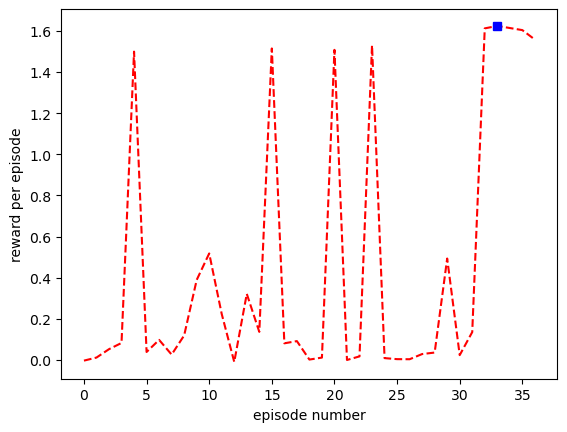

In [ ]:
print("Average reward of last 100 episodes is {0}".format(np.max(rewards_per_episode_2[-100:])))
plt.plot(list(range(len(rewards_per_episode_2))), rewards_per_episode_2, 'r--',ep_re2, re_episode_trial2, 'bs')
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

Average reward of last 100 episodes is 118


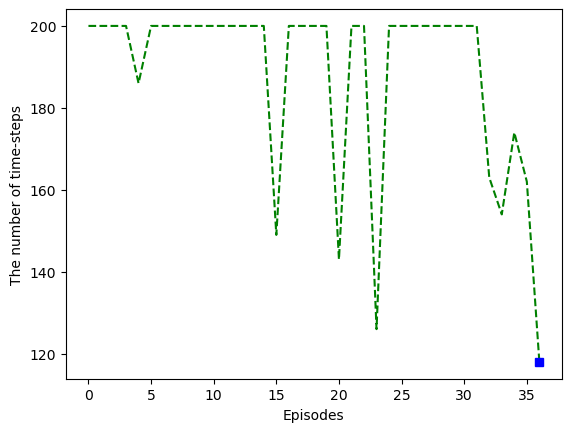

In [ ]:

print("Average reward of last 100 episodes is {0}".format(np.min(steps_per_episode_2[-100:])))
plt.plot(list(range(len(steps_per_episode_2))), steps_per_episode_2, 'g--', ep_st2,ste2, 'bs')
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

## **Test The Agent(Optimal solution = Trial 2)**
### Best performance with the Second hyperparameters(model_weights_2.h5)

In [ ]:
episodes=[]
rewards_per_episode_test=[]
for_steps_test= []

In [ ]:
def play_game(ml_model, games=10):

    for i_episode in range(games):
        # Define Reward Var
        episode_reward = 0
        steps_test=0

        # Reset Env for the Game
        observation = env.reset()

        while True:
            env.render()

            # Predict Next Movement
            current_action_pred = ml_model.predict(observation.reshape(1, 2))[0]

            # Define Movement
            current_action = np.argmax(current_action_pred)

            # Make Movement
            observation, reward, done, info = env.step(current_action)
            steps_test+=1
            episode_reward += reward

            if done:
                print(f"Episode finished after {i_episode+1} steps", end='')
                # Update Reward Value
                rewards_per_episode_test.append(episode_reward)
                for_steps_test.append(steps_test)
                break

In [ ]:
#build the structural of model
def build_model():
    init = he_normal(seed = 1000)
    model = Sequential()
    model.add(Dense(64, input_dim=2,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128,kernel_initializer = init))  # modify this layer to have 128 neurons
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(3, activation=LeakyReLU(alpha=0.1),kernel_initializer = init))
    model.compile(loss="mean_squared_error",optimizer=Adam(learning_rate = 0.0001))
    return model

In [ ]:
mymodel = build_model()
mymodel.load_weights("model_weights_2.h5")
play_game(mymodel)

1/1 [==============================] - 0s 15ms/step
Episode finished after 10 steps

In [ ]:
re_t=np.array(rewards_per_episode_test).max()
ste_t=np.array(for_steps_test).min()

ep_ret = rewards_per_episode_test.index(re_t)
ep_stt = for_steps_test.index(ste_t)

### Reward per episode

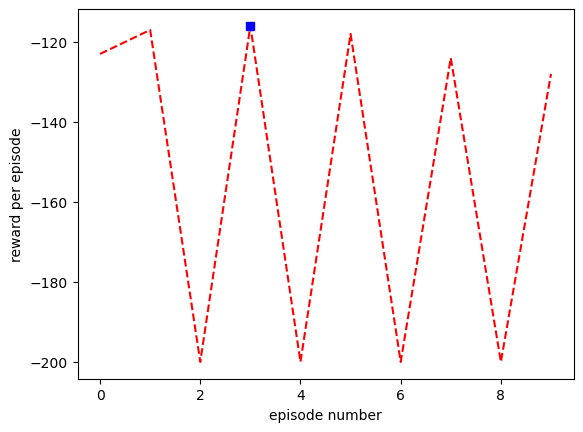

In [ ]:
plt.plot(list(range(len(rewards_per_episode_test))), rewards_per_episode_test, 'r--',  ep_ret,re_t, 'bs')
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.show()

### No. of time-steps per episode

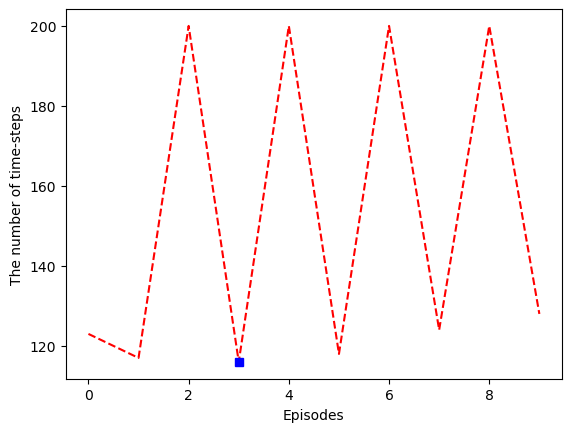

In [ ]:
plt.plot(np.arange(len(for_steps_test)), for_steps_test, 'r--',  ep_stt,ste_t, 'bs')
plt.ylabel('The number of time-steps')
plt.xlabel('Episodes')
plt.show()

# **Second Methodology of using `Deep Q-Learning`**

> **Shallow learning** algorithms can also be used in reinforcement learning, which is a type of machine learning that involves training an agent to make decisions based on rewards and punishments received from the environment.

> In reinforcement learning, the agent interacts with the environment and receives feedback in the form of rewards or penalties based on its actions. The goal of the agent is to learn a policy, which is a mapping from states to actions, that maximizes the cumulative reward over time.

> Shallow learning algorithms can be used to learn the policy of the agent. Here are some common terms used in reinforcement learning:

  1. Q-learning: A popular reinforcement learning algorithm that uses a table to store the expected reward for each state-action pair.

  2. Deep Q-network (DQN): A variant of Q-learning that uses a deep neural network to approximate the Q-values.

  3. Policy gradient: A reinforcement learning algorithm that directly optimizes the policy using gradient descent.

  4. Actor-critic: A reinforcement learning algorithm that uses two networks: an actor network that learns the policy and a critic network that learns to estimate the value function.

  5. Exploration-exploitation tradeoff: The balance between taking actions that are known to be good (exploitation) and exploring new actions to discover potentially better ones (exploration).

> Shallow learning algorithms can be used to learn the policy of the agent in reinforcement learning by approximating the Q-values or the policy directly. However, these algorithms may struggle with high-dimensional state spaces or complex environments. In these cases, deep reinforcement learning algorithms, which use deep neural networks to represent the policy or the value function, may be more suitable.

In [ ]:
num_episodes = 1000
verbose = True
print_every = 100
target_avg_reward_100ep = 10
rewards = []
running_rewards = []
restore_model = True
successes = 0
gamma=0.95
epsilon=.2

In [ ]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('MountainCar-v0')
env.reset()
# img = plt.imshow(env.render('rgb_array'))

array([-0.55108426,  0.        ])

In [ ]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        self.num_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.fc1 = torch.nn.Linear(self.state_dim,64,'relu')
        self.fc2 = torch.nn.Linear(64,self.num_actions,'linear')

    def forward(self,x):
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

In [ ]:
class Policy2(nn.Module):

    def __init__(self):
        super(Policy2, self).__init__()
        self.num_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.fc1 = torch.nn.Linear(self.state_dim,64,'linear')
        self.hidden1 = nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(64,64,'linear')
        self.hidden2 = nn.Dropout(0.08)
        self.fc3 = torch.nn.Linear(64,32,'linear')
        self.hidden3 = nn.Dropout(0.05)
        self.fc4 = torch.nn.Linear(32,16,'linear')
        self.fc5 = torch.nn.Linear(16,self.num_actions,'linear')

    def forward(self,x):

        x = self.hidden1(self.fc1(x))
        x = self.hidden2(F.relu(self.fc2(x)))
        x = self.hidden3(F.relu(self.fc3(x)))
        x = F.relu(self.fc4(x))
        y = F.relu(self.fc5(x))
        return y

In [ ]:
def get_policy_values(state,policy):
    state = Variable(torch.from_numpy(state)).type(torch.FloatTensor).unsqueeze(0)
    policy_values = policy(state)
    return policy_values

In [ ]:
def generate_episode(policy,loss_fn, optimizer, successes, epsilon, gamma, t_max=1000):

    states, actions, rewards, log_probs = [], [], [], []
    state = env.reset()

    for t in range(t_max):
        Q = get_policy_values(state,policy)

        if np.random.rand() <= epsilon:
            action = random.randrange(policy.num_actions)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()


       # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)

        # Adjust reward based on car position
        reward = state_1[0] + 0.5

        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
            print("Solved ",done)

        # Find max Q for t+1 state
        Q1 = get_policy_values(state_1,policy)
        maxQ1, _ = torch.max(Q1, -1)

        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[0][action] = reward + torch.mul(maxQ1.detach(), gamma)

        # Calculate loss
        loss = loss_fn(Q, Q_target)

        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        rewards.append(reward)

        if done:
            if state_1[0] >= 0.5:
                epsilon *= .9
                successes += 1
            break
        else:
            state = state_1
    return policy, loss_fn, rewards, epsilon, successes

In [ ]:
def play_episodes(policy):
    state = env.reset()
    img = plt.imshow(env.render('rgb_array')) # only call this once

    done = False
    while not done:
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)

        Q = get_policy_values(state,policy)
        _, action = torch.max(Q, -1)
        state,reward,done,_ = env.step(action.item())

In [ ]:
def plot_rewards(rewards, running_rewards):
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    plt.subplots_adjust(hspace=.5)

    ax1.set_title('Episodic rewards')
    ax1.plot(rewards, label='Episodic rewards')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Rewards")

    ax2.set_title('Running rewards')
    ax2.plot(running_rewards, label='Running rewards')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Average rewards")

    plt.show(fig)

In [ ]:
def test(policy, episode, t_max=1000):
    # if episode % 100 == 0 and episode > 10:
    if episode % 10 == 0 and episode > 5:
        test_episodes = 5
        total_test_reward = 0
        total_test_steps = 0
        total_reward = []
        for _ in range(test_episodes):
            done = False
            state = env.reset()
            test_steps = 0
            for j in range(t_max):
                Q = get_policy_values(state,policy)
                _, action = torch.max(Q, -1)
                state,reward,done,_ = env.step(action.item())
                total_test_reward += reward
                test_steps += 1


                # Adjust reward based on car position
                reward = state[0] + 0.5

                # Adjust reward for task completion
                if state[0] >= 0.5:
                    reward += 1
                    print("Solved ",done)
                total_reward.append(reward)
                if done:
                    break
                total_test_steps += test_steps

            if episode == 1:
              continue;
            else:
              avg_test_reward = total_test_reward / test_episodes
              avg_test_steps = total_test_steps / test_episodes
              print("test:Episode {} completed in {}. cumulative test reward {}. Average test timesteps {}. Average test rewards {}.".format(
                episode, test_steps, total_test_reward, avg_test_steps, avg_test_reward))

    return False

### **Build the Train method of the agent**

In [ ]:
def train(agent,policy,loss_fn, optimizer,for_steps,num_episodes = 1000):
    rewards = []
    running_rewards = []
    successes = 0
    epsilon = .1
    gamma=0.9
    for i in range(num_episodes):

        state = env.reset()
        steps = 0
        policy,loss_fn,reward,epsilon,successes = generate_episode(policy,loss_fn,optimizer, successes, epsilon, gamma)
        rewards.append(sum(reward))
        running_reward = np.mean(reward)
        running_rewards.append(running_reward)
        done = False
        score = 0

        while not done:
            Q = get_policy_values(state,policy)
            _, action = torch.max(Q, -1)
            next_state,reward,done,_ = env.step(action.item())

            if next_state[0] >= 0.5:
                reward += 1
            agent.append_sample(state, action, reward, next_state, done)

            # # train after each step
            # train()

            # add reward to the total score of this episode and number of steps
            state = next_state
            steps += 1
            score += reward
            if done:
                agent.update_target_model()

            # store total reward obtained in this episode
            for_steps.append(steps)

        if verbose:
                # print("Episode: {}. Running reward: {}. Epsilon: {}".format(i, running_reward, epsilon))
                print("train:Episode {} completed in {}. Cumulative train rewards {}. Average train timesteps {}. Average reward over episodes {}".format(
            i, -steps, sum(rewards), np.mean(for_steps), running_reward))

        if test(policy, i):
            print("Ran {} episodes. Solved after {} episodes.".format(i+1, i-100+1))
            break

        if i == num_episodes-1 and not successes:
            print("Couldn't solve after {} episodes".format(num_episodes))

    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/num_episodes*100))
    return rewards, running_rewards,for_steps

### **Trial 1 of Shallow learning**

- The agent in Trial 1 is trained using a policy implemented in the Policy class.
- The agent is initialized with a MountainCarAgent object, with specified parameters for discount factor, learning rate, epsilon, and epsilon decay.
- The loss function used is mean squared error (MSE).
- The optimizer used is Adam optimizer with a learning rate of 0.001.
- The train function is called to train the agent for 1000 episodes.

In [ ]:
class MountainCarAgent():
    def __init__(self, action_size, state_size, discount_factor, learning_rate,
                 epsilon, epsilon_decay, epsilon_min):

        # parameters
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_max = 1
        self.load_model = True
        self.epsilon_min = epsilon_min
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        # action and state sizes
        self.action_size = action_size
        self.state_size = state_size

        # build the NN model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        initializer = he_normal(seed=1000)
        model = Sequential()
        model.add(Dense(48, input_dim=2, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(64, kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.action_size, activation=LeakyReLU(alpha=0.1), kernel_initializer=initializer))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0001))
        return model

    def get_action(self, state):
        if random.uniform(0, 1) <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train_model(self):
        if len(self.memory) > self.batch_size:
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.target_model.predict(update_output)
            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:  # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1,verbose=0, validation_split=0.1);

    def save_model_weights(self, name):
        self.model.save_weights(name)


In [ ]:
verbose = True
print_every = 10
running_reward = None
rewards = []
running_rewards = []
restore_model = True
for_steps = []

### **Train the agent**
For the test performance, after every 10 episodes of training. run the estimated policy in the environment for 5 test episodes and report the mean over (i) cumulative reward per episode obtained by the agent, and (ii) the number of timesteps required to solve the task per episode of experience.

In [ ]:
# Get environment
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state = env.reset()
policy = Policy()
agent_1 = MountainCarAgent(action_size, state_size, discount_factor=0.95, learning_rate=0.02, epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(policy.parameters(), lr=0.001)
rewards, running_rewards,for_steps= train(agent_1,policy, loss_fn, optimizer, for_steps,num_episodes=1000)

train:Episode 0 completed in -1. Cumulative train rewards 14.440346576527395. Average train timesteps 1.0. Average reward over episodes 0.07220173288263701
train:Episode 1 completed in -1. Cumulative train rewards 35.663243483874034. Average train timesteps 1.0. Average reward over episodes 0.10611448453673322
train:Episode 2 completed in -1. Cumulative train rewards 49.777870021633916. Average train timesteps 1.0. Average reward over episodes 0.07057313268879939
train:Episode 3 completed in -1. Cumulative train rewards 67.37406297224291. Average train timesteps 1.0. Average reward over episodes 0.087980964753045
train:Episode 4 completed in -1. Cumulative train rewards 89.91643658484695. Average train timesteps 1.0. Average reward over episodes 0.11271186806302014
train:Episode 5 completed in -1. Cumulative train rewards 103.79272183242672. Average train timesteps 1.0. Average reward over episodes 0.06938142623789889
train:Episode 6 completed in -1. Cumulative train rewards 118.108217

### **Plot the Rewards**

<ipython-input-81-429f642f25a6>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


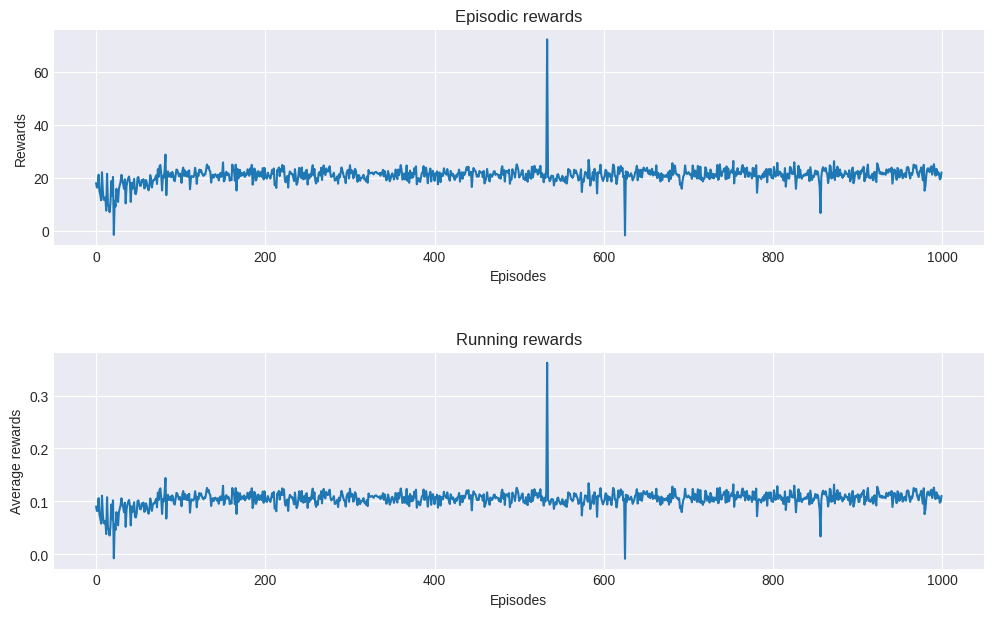

In [ ]:
plot_rewards(rewards, running_rewards)

### **Animation of game**

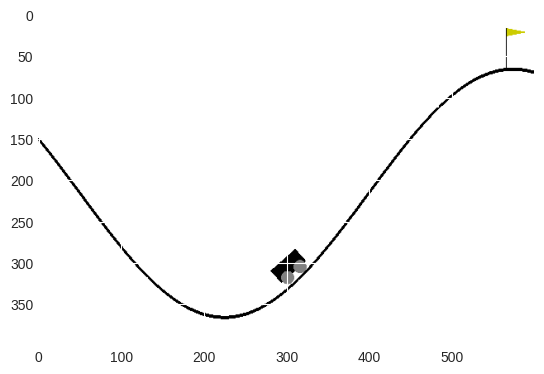

In [ ]:
play_episodes(policy)

### **Trial_2 of Shallow learning**

- The agent in Trial 2 is trained using a different policy implemented in the Policy2 class.
- The agent is initialized with a MountainCarAgent object, with the same specified parameters as in Trial 1.
- The loss function used is also mean squared error (MSE).
- The optimizer used is Adam optimizer with a learning rate of 0.001.
- The train function is called to train the agent for 1000 episodes.

In [ ]:
verbose = True
running_reward = None
rewards = []
running_rewards = []
restore_model = True
for_steps = []

### **Train the agent**
For the test performance, after every 10 episodes of training. run the estimated policy in the environment for 5 test episodes and report the mean over (i) cumulative reward per episode obtained by the agent, and (ii) the number of timesteps required to solve the task per episode of experience.

In [ ]:
# Get environment
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
state = env.reset()
policy2 = Policy2()
agent_1 = MountainCarAgent(action_size, state_size, discount_factor=0.95, learning_rate=0.02, epsilon=1, epsilon_decay=0.99, epsilon_min=0.02)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(policy2.parameters(), lr=0.001)
rewards, running_rewards,for_steps = train(agent_1,policy2, loss_fn, optimizer, for_steps,num_episodes=1000)

train:Episode 0 completed in -1. Cumulative train rewards -27.23585557245831. Average train timesteps 1.0. Average reward over episodes -0.13617927786229156
train:Episode 1 completed in -1. Cumulative train rewards -62.4951550208373. Average train timesteps 1.0. Average reward over episodes -0.17629649724189506
train:Episode 2 completed in -1. Cumulative train rewards -93.2754705467051. Average train timesteps 1.0. Average reward over episodes -0.1539015776293389
train:Episode 3 completed in -1. Cumulative train rewards -123.63429830446933. Average train timesteps 1.0. Average reward over episodes -0.15179413878882111
train:Episode 4 completed in -1. Cumulative train rewards -156.14242490076197. Average train timesteps 1.0. Average reward over episodes -0.16254063298146326
train:Episode 5 completed in -1. Cumulative train rewards -185.538432423401. Average train timesteps 1.0. Average reward over episodes -0.14698003761319514
train:Episode 6 completed in -1. Cumulative train rewards -2

### **Plot the Rewards**

<ipython-input-81-429f642f25a6>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


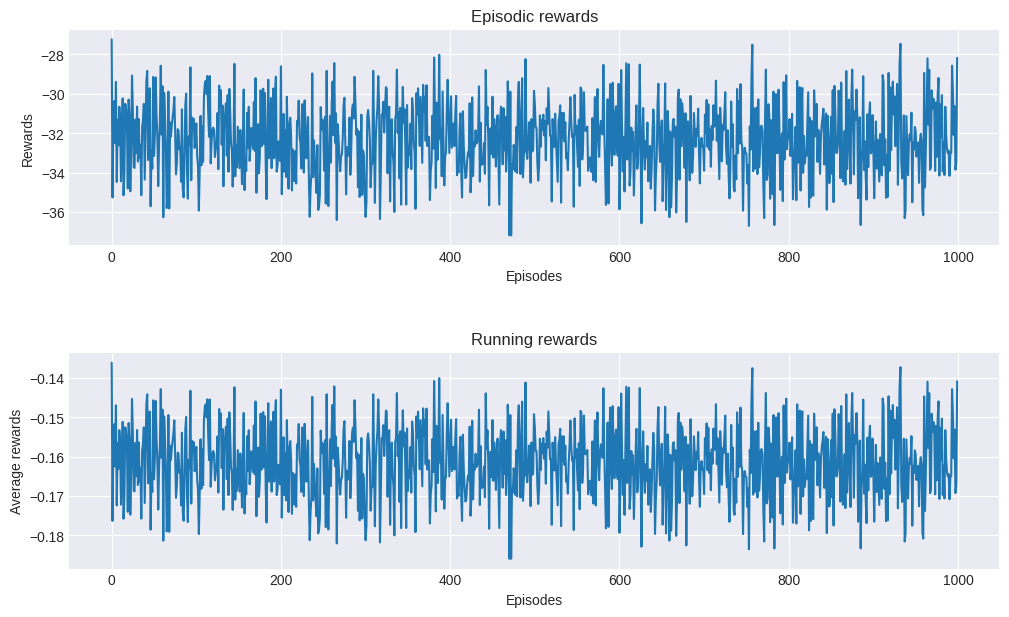

In [ ]:
plot_rewards(rewards, running_rewards)

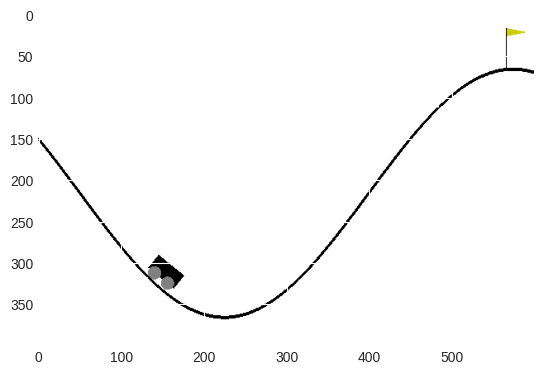

In [ ]:
play_episodes(policy2)

### **Required 5 (Hyperparemeter search (Tuning))**
  - The requirment was : Apply this requirement ,"If applicable please do an in-depth hyper-parameter search. Report the justification of your choices for each hyper-parameters with supporting plots"
  
  - When we tried to apply it we faced a problem in the resorces needed and need too long time so we can't get a result from it .
  - our trial is in the following part .

In [ ]:

class QLearningAgent:
    def __init__(self, state_size, action_size, seed, alpha=0.5, gamma=1.0, eps_decay=0.999):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.alpha = alpha
        self.gamma = gamma
        self.eps_decay = eps_decay

        self.Q = np.zeros((self.state_size, self.action_size))
        self.eps = 1.0

    def act(self, state):
        """Select action using epsilon-greedy policy."""
        if np.random.rand() < self.eps:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.Q[state])

    def learn(self, state, action, reward, next_state, done):
        """Update value estimate for the most recent experience."""
        q_next = np.max(self.Q[int(next_state)]) if not done else 0
        q_target = reward + (self.gamma * q_next)
        self.Q[state, action] += self.alpha * (q_target - self.Q[state, action])

    def decay_epsilon(self):
        """Decay epsilon value."""
        self.eps = max(self.eps_decay * self.eps, 0.01)


def train_qlearning(agent, env, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train an agent using Q-learning.

    Params
    ======
        agent (QLearningAgent): the agent to train
        env (OpenAI Gym environment): the environment to train the agent in
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay rate of epsilon
    """
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        agent.decay_eps()
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores[-100:])))
        if np.mean(scores[-100:]) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores[-100:])))
            break
    return scores

In [ ]:

def hyperparam_search(env, seed, alpha_range=(0.1, 1.0), gamma_range=(0.9, 1.0), n_trials=10, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Perform a hyperparameter search for Q-learning.

    Params
    ======
        env (OpenAI Gym environment): the environment to train the agent in
        seed (int): random seed
        alpha_range (tuple of floats): range of learning rate values to try
        gamma_range (tuple of floats): range of discount factor values to try
        n_trials (int): number of hyperparameter combinations to try
        n_episodes (int): maximum number of training episodesfor each hyperparameter combination
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay rate of epsilon

    Returns
    =======
        best_alpha (float): best learning rate found
        best_gamma (float): best discount factor found
    """
    best_avg_score = -np.inf
    best_alpha = None
    best_gamma = None
    all_scores = []

    for i in range(n_trials):
        alpha = np.random.uniform(*alpha_range)
        gamma = np.random.uniform(*gamma_range)
        state_size = int(np.prod(env.observation_space.shape))
        agent = QLearningAgent(state_size, env.action_space.n, seed, alpha=alpha, gamma=gamma, eps_decay=eps_decay)
        scores = train_qlearning(agent, env, n_episodes=n_episodes, max_t=max_t, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)
        avg_score = np.mean(scores[-100:])
        all_scores.append(scores)
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_alpha = alpha
            best_gamma = gamma

    print(f"Best alpha found: {best_alpha}")
    print(f"Best gamma found: {best_gamma}")

    plt.plot(all_scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()

    return best_alpha, best_gamma

In [ ]:
import gym

env = gym.make('MountainCar-v0')
seed = 0

best_alpha, best_gamma = hyperparam_search(env, seed, alpha_range=(0.1, 1.0), gamma_range=(0.9, 1.0), n_trials=10, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

# **2- Training the Agent Using `Q-learning`**

> ### Reinforcement Learning
  
  - **Q-learning** is a popular reinforcement learning algorithm that can be used to solve the Mountain Car problem. The Mountain Car problem is a classic reinforcement learning problem in which an underpowered car must climb a steep hill to reach a goal position. The car cannot simply drive up the hill, but instead must use momentum to climb the hill.

  - Q-learning is a model-free algorithm that learns an optimal policy for the agent by estimating the expected reward for each state-action pair. The basic idea behind Q-learning is to update the Q-values iteratively based on the rewards received from the environment.

  Here is the general algorithm for Q-learning:

    1. Initialize the Q-values for all state-action pairs to zero or a small random value.
    2. Observe the current state s.
    3. Select an action a using an exploration-exploitation strategy, such as epsilon-greedy or softmax.
    4. Take the action a and observe the reward r and the next state s'.
    5. Update the Q-value for the current state-action pair using the Q-learning update rule:

    Q(s, a) = Q(s, a) + alpha * (r + gamma * max(Q(s', a')) - Q(s, a))

   where alpha is the learning rate and gamma is the discount factor.

    6. Set the current state to the next state s'.
    7. Repeat steps 3-6 until the goal state is reached or a maximum number of iterations is reached.

> In the context of the Mountain Car problem, the Q-values represent the expected reward for each state-action pair, where the state is the position and velocity of the car and the action is the force applied to the car. The Q-learning algorithm can learn an optimal policy for the agent to reach the goal position by iteratively updating the Q-values based on the rewards received from the environment.

> Q-learning can be a powerful algorithm for solving reinforcement learning problems, but it may require a large number of iterations to converge to an optimal policy. In addition, the choice of hyperparameters such as the learning rate and discount factor can significantly affect the performance of the algorithm.


> We will now use Q-Learning to produce a car that learns to drive itself.


###**START**

In [ ]:
# creates a virtual display
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
#start the virtual display and return a handle to it
_ = _display.start()

### **Q Learning**

This implementation of the Q-learning algorithm trains an agent to find an optimal policy for a given environment with a discrete action space. The agent learns to balance exploration and exploitation and uses the Bellman equation to update its Q-values over time.

In [ ]:
train_avg_ts=[]
test_avg_ts=[]
test_rewards=[]
train_rewards=[]

class QLearning():

    def __init__(self,
                 env,
                 bins,
                 episodes=10000,
                 num_decay=None,
                 exploration_rate=0.5,
                 exploration_rate_decay=0.9,
                 alpha=0.5,
                 alpha_decay=0.9,
                 gamma=0.99,
                 reward_func=None):
        """
        Initializes the Q-learning agent with the given parameters.

        Parameters:
        - env: the environment to interact with
        - bins: the number of bins to discretize the observation space
        - episodes: the number of episodes to train for
        - num_decay: the number of segments to divide the training into for alpha and exploration rate decay
        - exploration_rate: the initial exploration rate
        - exploration_rate_decay: the decay rate for the exploration rate
        - alpha: the initial learning rate
        - alpha_decay: the decay rate for the learning rate
        - gamma: the discount factor for future rewards
        - reward_func: a custom reward function
        """
        self.env = env
        self.bins = bins
        self.episodes = episodes
        self.num_decay = num_decay
        self.exploration_rate = exploration_rate
        self.exploration_rate_base = exploration_rate
        self.exploration_rate_decay = exploration_rate_decay
        self.alpha = alpha
        self.alpha_base = alpha
        self.alpha_decay = alpha_decay
        self.gamma = gamma
        self.num_action = env.action_space.n
        self.Q = {}
        self.reward_func = reward_func

    def set_env(self, env):
        """
        Updates the environment.

        Parameters:
        - env: the new environment
        """
        self.env = env

    def discretization(self, value, bins):
        """
        Returns the index of the bin that the given value belongs to.

        Parameters:
        - value: the value to discretize
        - bins: the bin edges

        Returns:
        - The index of the bin that the value belongs to.
        """
        return np.digitize(x=[value], bins=bins)[0]

    def to_state(self, obs):
        """
        Converts the observation to a discrete state.

        Parameters:
        - obs: the observation

        Returns:
        - A tuple representing the discrete state.
        """
        state = []
        for i, o in enumerate(obs):
            state.append(self.discretization(o, self.bins[i]))
        state = tuple(state)
        return state

    def get_action(self, state, mode='greedy'):
        """
        Returns an action to take based on the given state.

        Parameters:
        - state: the state to choose an action for
        - mode: either 'greedy' or 'non_greedy'

        Returns:
        - The action to take.
        """
        p = np.random.uniform(0, 1)

        if p < self.exploration_rate and mode == 'greedy':
            return random.choice([i for i in range(self.num_action)])
        x = []
        for action in range(self.num_action):
            if (state, action) not in self.Q:
                self.Q[(state, action)] = 0
            x.append(self.Q[(state, action)])
        return np.argmax(x)

    def train(self,
              train_episodes=None,
              test_interval=1,
              verbose=True):
        """
        Trains the Q-learning agent for the specified number of episodes and returns the average timesteps per episode.
        The method also updates the Q-values and decays the exploration rate and learning rate over time.

        Parameters:
        - train_episodes: the number of episodes to train for
        - test_interval: the interval at which to test the agent
        - verbose: whether to print training progress

        Returns:
        - An array of test timesteps and their corresponding episodes.
        """
        if not train_episodes:
            train_episodes = self.episodes
        timesteps = np.zeros((train_episodes//test_interval, 2))
        for episode in range(train_episodes):

            obs = self.env.reset()
            state = self.to_state(obs)
            timestep = 0
            while True:

                timestep += 1
                action = self.get_action(state)
                obs, reward, done, _ = self.env.step(action)

                if self.reward_func:
                    reward = self.reward_func(obs, self.env)

                state_prime = self.to_state(obs)
                action_prime = self.get_action(state_prime, 'non_greedy')

                if (state_prime, action_prime) not in self.Q:
                    self.Q[(state_prime, action_prime)] = 0.1 * np.random.randn(1)

                if (state, action) not in self.Q:
                    self.Q[(state, action)] = 0.1 * np.random.randn(1)

                self.Q[(state, action)] += self.alpha * (reward +
                    self.gamma * self.Q[(state_prime, action_prime)] -
                    self.Q[(state, action)])
                state = state_prime

                if done:
                    if verbose:
                        train_avg_ts.append(timestep)
                        train_reward=-timestep
                        train_rewards.append(train_reward)

                        print("train:Episode %d completed in %d. Cumulative train rewards %d. Average train timesteps %d. Average reward over episodes %d" % (episode,train_reward, timestep,np.mean(train_avg_ts), np.mean(train_rewards)))
                    break
            if episode % test_interval == 0:
                test_timesteps = self.test(5, True)
                timesteps[episode // test_interval, :] = episode, test_timesteps[0, 1]

            if self.num_decay:
                decay_segment_length = train_episodes // self.num_decay
                self.alpha = self.alpha_base * (self.alpha_decay**(episode // decay_segment_length))
                self.exploration_rate = self.exploration_rate_base * (self.exploration_rate_decay **
                                                    (episode // decay_segment_length))

        return timesteps

    def test(self, test_episodes=1000, verbose=True):
        timesteps = np.zeros((test_episodes, 2), dtype=int)
        avg = 0
        for episode in range(test_episodes):
            cnt = 0
            obs = self.env.reset()
            total_rewards = 0
            while True:
                cnt += 1
                state = self.to_state(obs)
                action = self.get_action(state, 'non_greedy')
                obs, reward, done, _ = self.env.step(action)
                total_rewards += reward

                if done:
                    test_rewards.append(total_rewards)
                    avg += cnt
                    timesteps[episode, :] = episode, total_rewards
                    if verbose:
                        test_avg_ts.append(cnt)
                        print("test :Episode %d completed in %d . cumulative test reward %d . Average test timesteps %d. Average test rewards %d ." % (episode, cnt,total_rewards,np.mean(test_avg_ts),np.mean(test_rewards)))
                    break


        return timesteps

    def visualize(self, pic_name, timesteps, mode='train'):
            # fig,(ax1,ax2,ax3,ax4) = plt.subplots(4)
            plt.plot(np.arange(0,len(train_rewards)), train_rewards)
            plt.hlines(y=np.max(train_rewards), xmin=0, xmax=len(train_rewards), colors='r', linestyles='--', lw=2)
            plt.set_title = 'Rewards over episodes during training'
            plt.xlabel='episode'
            plt.ylabel='rewards'
            plt.show()
            print("Rewards over episodes during training\n")
            plt.plot(np.arange(0,len(train_avg_ts)), train_avg_ts)
            plt.hlines(y=np.min(train_avg_ts), xmin=0, xmax=len(train_avg_ts), colors='r', linestyles='--', lw=2)
            plt.title = 'Timesteps over episodes during training'
            plt.xlabel='episode'
            plt.ylabel='timesteps'
            plt.show()
            print("Timesteps over episodes during training\n")

            plt.plot(np.arange(0,len(test_rewards)), test_rewards)
            plt.hlines(y=np.max(test_rewards), xmin=0, xmax=len(test_rewards), colors='r', linestyles='--', lw=2)
            plt.title = 'Rewards over episodes during test'
            plt.xlabel='episode'
            plt.ylabel='rewards'
            plt.show()
            print("Rewards over episodes during test\n")


            plt.plot(np.arange(0,len(test_avg_ts)), test_avg_ts)
            plt.hlines(y=np.min(test_avg_ts), xmin=0, xmax=len(test_avg_ts), colors='r', linestyles='--', lw=2)
            plt.title = 'Timesteps over episodes during training'
            plt.xlabel='episode'
            plt.ylabel='timesteps'
            plt.show()
            print("Timesteps over episodes during training\n")




            # ax1.set(xlabel='episode',ylabel='rewards',title=ax1.title)

            # ax2.set(xlabel='episode',ylabel='rewards',title=ax2.title)

            # ax3.set(xlabel='episode',ylabel='rewards',title=ax3.title)

            # ax4.set(xlabel='episode',ylabel='rewards',title=ax4.title)
            # fig.savefig(pic_name)
            plt.show()

    def save_Qtable(self, filename):
        f = open(filename, 'wb')
        pkl.dump(self.Q, f, 3)


# print('average timesteps = ', avg/NUM_EPISODES)
# print('max timestep = ', np.max(timesteps))
# print('means = {}, std = {}'.format(np.mean(timesteps), np.std(timesteps)))

### **The MountainCar-v1 environment using the Q-learning algorithm**

- The MountainCar-v1 environment is registered, and the number of actions and observation space bins are set.

- A QLearning object is initialized with the MountainCar-v1 environment and the specified parameters.

- The agent is trained using the train() method of the QLearning object. The method trains the agent for the specified number of episodes and returns the average timesteps per episode. The agent's Q-values are updated using the Bellman equation, and the exploration rate and learning rate are decayed over time. The test_timesteps list is used to store the test timesteps obtained during testing.

## **Trial 1 :**


ALPHA = 0.05 && EXPLORATION_RATE = 0.6

## **Trial 2:**


ALPHA = 0.3 && EXPLORATION_RATE = 0.8

## **Trial 3:**

ALPHA = 0.5 && EXPLORATION_RATE = 0.2

### **Train the agent**
For the test performance, after every 10 episodes of training. run the estimated policy in the environment for 5 test episodes and report the mean over (i) cumulative reward per episode obtained by the agent, and (ii) the number of timesteps required to solve the task per episode of experience.


### **Trial 1**

- ALPHA = 0.05 && EXPLORATION_RATE = 0.6

Streaming output truncated to the last 5000 lines.
train:Episode 2670 completed in -300. Cumulative train rewards 300. Average train timesteps 295. Average reward over episodes -295
test :Episode 0 completed in 153 . cumulative test reward -153 . Average test timesteps 245. Average test rewards -245 .
test :Episode 1 completed in 155 . cumulative test reward -155 . Average test timesteps 245. Average test rewards -245 .
test :Episode 2 completed in 150 . cumulative test reward -150 . Average test timesteps 245. Average test rewards -245 .
test :Episode 3 completed in 154 . cumulative test reward -154 . Average test timesteps 244. Average test rewards -244 .
test :Episode 4 completed in 154 . cumulative test reward -154 . Average test timesteps 244. Average test rewards -244 .
train:Episode 2671 completed in -300. Cumulative train rewards 300. Average train timesteps 295. Average reward over episodes -295
train:Episode 2672 completed in -239. Cumulative train rewards 239. Average train 

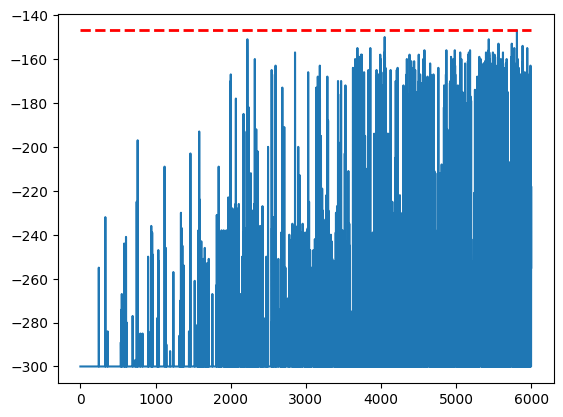

Rewards over episodes during training



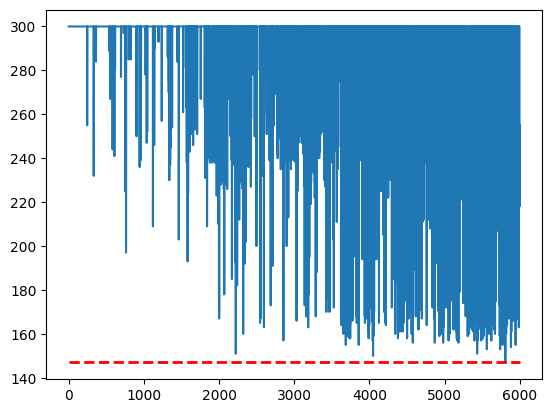

Timesteps over episodes during training



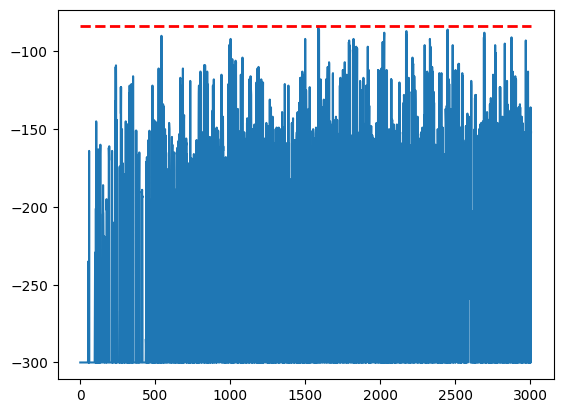

Rewards over episodes during test



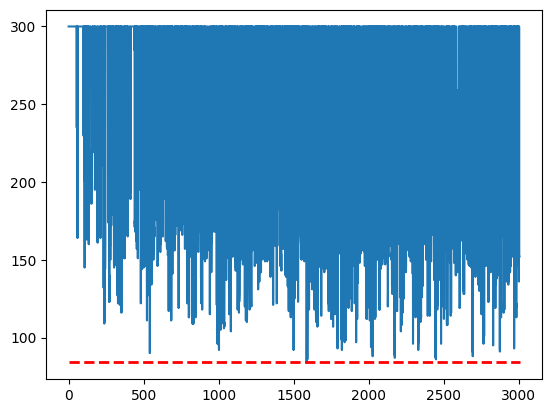

Timesteps over episodes during training

train max rewards =  -147
train means = -285.67333333333335, std = 32.736660727013
test max rewards =  -84.0
test means = -231.14276206322796, std = 73.23185380015047


In [ ]:
# Initialize empty lists to store training and testing results
train_avg_ts=[]
test_avg_ts=[]

# Set the number of episodes, learning rate, discount factor, and exploration rate
NUM_EPISODES = 6000
TEST_EPISODES = 5
ALPHA_BASE = 0.05
ALPHA = ALPHA_BASE
ALPHA_DECAY_RATE = 0.9
GAMMA = 0.99
EXPLORATION_RATE_BASE = 0.6
EXPLORATION_RATE = EXPLORATION_RATE_BASE
EXPLORATION_RATE_DECAY = 0.95
NUM_DECAY = 10

# Register the MountainCar-v1 environment and set the number of actions and observation space bins
register(
    id='MountainCar-v1',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=300,
)


def mountain_car():
    env = gym.make('MountainCar-v1')
    test_evn = gym.wrappers.Monitor(env, './MountainCar-v1', force=True)
    NUM_ACTIONS = env.action_space.n
    CART_POS = np.linspace(-1.2, 0.6, 10)
    CART_VEL = np.linspace(-0.07, 0.07, 8)
    bins = (CART_POS, CART_VEL)
    # Initialize a QLearning object with the MountainCar-v1 environment and the specified parameters
    qlearning = QLearning(env,
                          bins,
                          num_decay=NUM_DECAY,
                          exploration_rate=EXPLORATION_RATE,
                          exploration_rate_decay=EXPLORATION_RATE_DECAY,
                          alpha=ALPHA,
                          gamma=GAMMA)
    # Set the test interval and train the agent
    test_interval = 10
    train_timesteps = qlearning.train(train_episodes=NUM_EPISODES, test_interval=test_interval)
    # Set the test environment and test the agent
    test_evn = gym.wrappers.Monitor(env, './videos/MountainCar-v1', force=True)
    qlearning.set_env(test_evn)
    test_timesteps = qlearning.test(test_episodes=TEST_EPISODES)
    # Visualize the training results and print the training and testing statistics
    qlearning.visualize('train_mountain.png', train_timesteps, mode='train')
    print('train max rewards = ', np.max(train_rewards))
    print('train means = {}, std = {}'.format(np.mean(train_rewards), np.std(train_rewards)))

    print('test max rewards = ', np.max(test_rewards))
    print('test means = {}, std = {}'.format(np.mean(test_rewards), np.std(test_rewards)))

    # Save the Q-table if the agent performs poorly in the test environment
    if np.mean(test_timesteps) < 100:
        qlearning.save_Qtable('Mountain_Q.pkl')


def main():
    mountain_car()


if __name__ == '__main__':
    main()

#### **Trial 1 observation:**

- The maximum reward achieved during training is -147.
- The average reward during training is -285.67 with a standard deviation of 32.74.
- The maximum reward achieved during testing is -84.
-The average reward during testing is -231.14 with a standard deviation of 73.23.

There are a graphes for testing and training performance at the end of **the last cell run**


### **Trial 2**

- ALPHA = 0.3 && EXPLORATION_RATE = 0.8


Streaming output truncated to the last 5000 lines.
train:Episode 2670 completed in -300. Cumulative train rewards 300. Average train timesteps 299. Average reward over episodes -290
test :Episode 0 completed in 300 . cumulative test reward -300 . Average test timesteps 297. Average test rewards -251 .
test :Episode 1 completed in 300 . cumulative test reward -300 . Average test timesteps 297. Average test rewards -251 .
test :Episode 2 completed in 300 . cumulative test reward -300 . Average test timesteps 297. Average test rewards -251 .
test :Episode 3 completed in 300 . cumulative test reward -300 . Average test timesteps 297. Average test rewards -251 .
test :Episode 4 completed in 300 . cumulative test reward -300 . Average test timesteps 297. Average test rewards -251 .
train:Episode 2671 completed in -300. Cumulative train rewards 300. Average train timesteps 299. Average reward over episodes -290
train:Episode 2672 completed in -300. Cumulative train rewards 300. Average train 

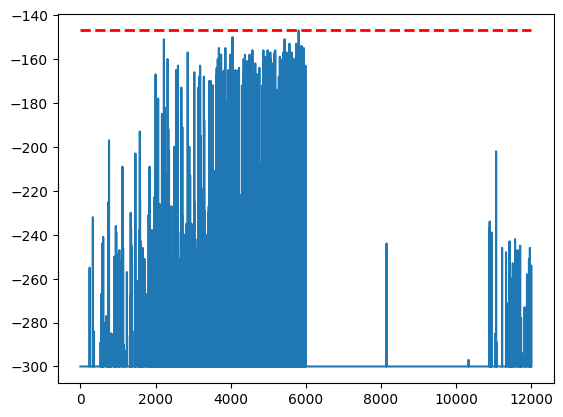

Rewards over episodes during training



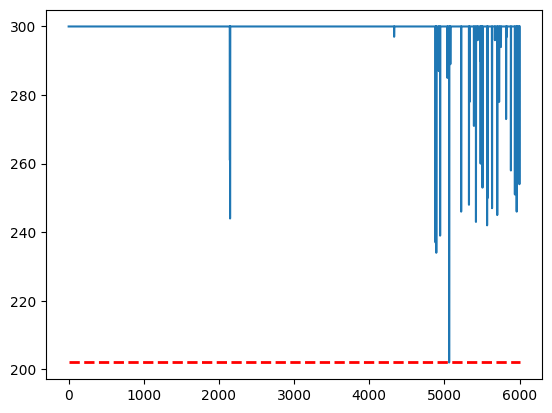

Timesteps over episodes during training



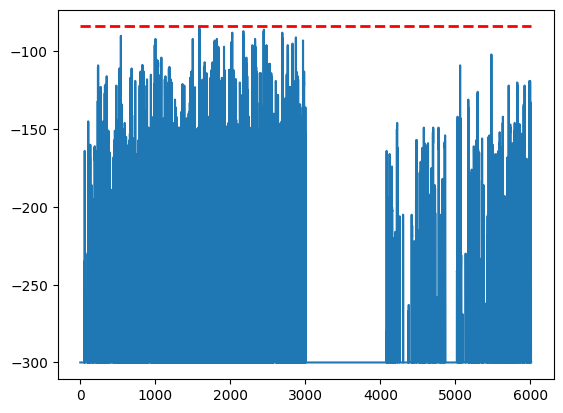

Rewards over episodes during test



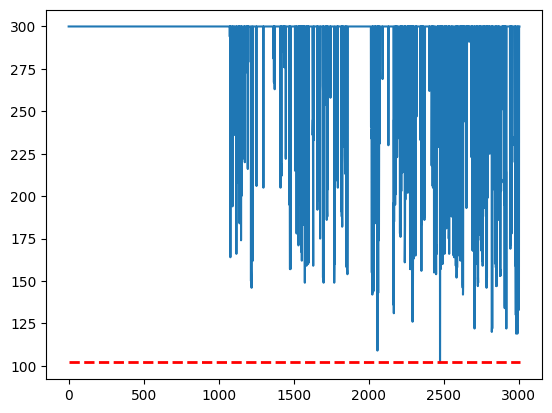

Timesteps over episodes during training

train max rewards =  -147
train means = -292.7230833333333, std = 24.316299070645098
test max rewards =  -84.0
test means = -257.86156405990016, std = 64.77762398596855


In [ ]:
# Initialize empty lists to store training and testing results
train_avg_ts=[]
test_avg_ts=[]

# Set the number of episodes, learning rate, discount factor, and exploration rate
NUM_EPISODES = 6000
TEST_EPISODES = 5
ALPHA_BASE = 0.3
ALPHA = ALPHA_BASE
ALPHA_DECAY_RATE = 0.9
GAMMA = 0.99
EXPLORATION_RATE_BASE = 0.8
EXPLORATION_RATE = EXPLORATION_RATE_BASE
EXPLORATION_RATE_DECAY = 0.95
NUM_DECAY = 10



def mountain_car():
    env = gym.make('MountainCar-v1')
    test_evn = gym.wrappers.Monitor(env, './MountainCar-v1', force=True)
    NUM_ACTIONS = env.action_space.n
    CART_POS = np.linspace(-1.2, 0.6, 10)
    CART_VEL = np.linspace(-0.07, 0.07, 8)
    bins = (CART_POS, CART_VEL)
    # Initialize a QLearning object with the MountainCar-v1 environment and the specified parameters
    qlearning = QLearning(env,
                          bins,
                          num_decay=NUM_DECAY,
                          exploration_rate=EXPLORATION_RATE,
                          exploration_rate_decay=EXPLORATION_RATE_DECAY,
                          alpha=ALPHA,
                          gamma=GAMMA)
    # Set the test interval and train the agent
    test_interval = 10
    train_timesteps = qlearning.train(train_episodes=NUM_EPISODES, test_interval=test_interval)
    # Set the test environment and test the agent
    test_evn = gym.wrappers.Monitor(env, './videos/MountainCar-v1', force=True)
    qlearning.set_env(test_evn)
    test_timesteps = qlearning.test(test_episodes=TEST_EPISODES)
    # Visualize the training results and print the training and testing statistics
    qlearning.visualize('train_mountain.png', train_timesteps, mode='train')
    print('train max rewards = ', np.max(train_rewards))
    print('train means = {}, std = {}'.format(np.mean(train_rewards), np.std(train_rewards)))

    print('test max rewards = ', np.max(test_rewards))
    print('test means = {}, std = {}'.format(np.mean(test_rewards), np.std(test_rewards)))
    # Save the Q-table if the agent performs poorly in the test environment
    if np.mean(test_timesteps) < 100:
        qlearning.save_Qtable('Mountain_Q.pkl')


def main():
    mountain_car()


if __name__ == '__main__':
    main()

### **Trial 2 obseravtion**:

- The maximum reward achieved during training is -147.
- The average reward during training is -292.72 with a standard deviation of 24.32.
- The maximum reward achieved during testing is -84.
- The average reward during testing is -257.86 with a standard deviation of 64.78.

There are a graphes for testing and training performance at the end of **the last cell run**

### **Trial 3**
- ALPHA = 0.5 && EXPLORATION_RATE = 0.2

Streaming output truncated to the last 5000 lines.
train:Episode 2670 completed in -300. Cumulative train rewards 300. Average train timesteps 294. Average reward over episodes -293
test :Episode 0 completed in 300 . cumulative test reward -300 . Average test timesteps 286. Average test rewards -263 .
test :Episode 1 completed in 300 . cumulative test reward -300 . Average test timesteps 286. Average test rewards -263 .
test :Episode 2 completed in 300 . cumulative test reward -300 . Average test timesteps 286. Average test rewards -263 .
test :Episode 3 completed in 300 . cumulative test reward -300 . Average test timesteps 286. Average test rewards -263 .
test :Episode 4 completed in 300 . cumulative test reward -300 . Average test timesteps 286. Average test rewards -263 .
train:Episode 2671 completed in -300. Cumulative train rewards 300. Average train timesteps 294. Average reward over episodes -293
train:Episode 2672 completed in -300. Cumulative train rewards 300. Average train 

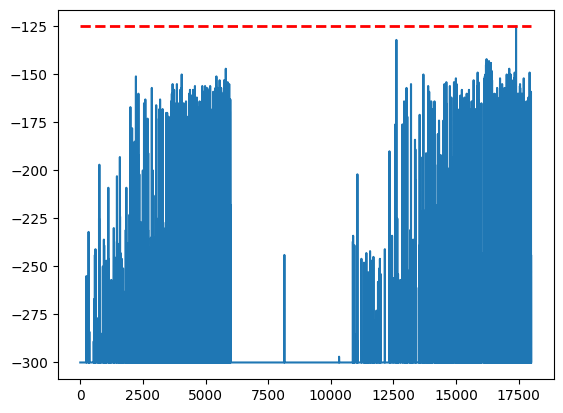

Rewards over episodes during training



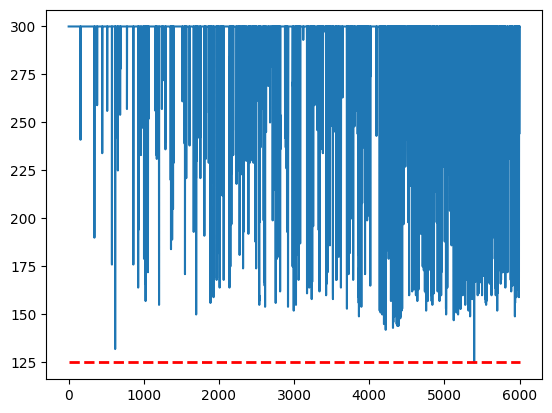

Timesteps over episodes during training



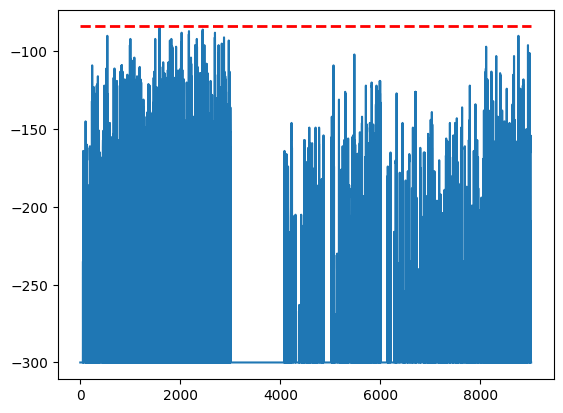

Rewards over episodes during test



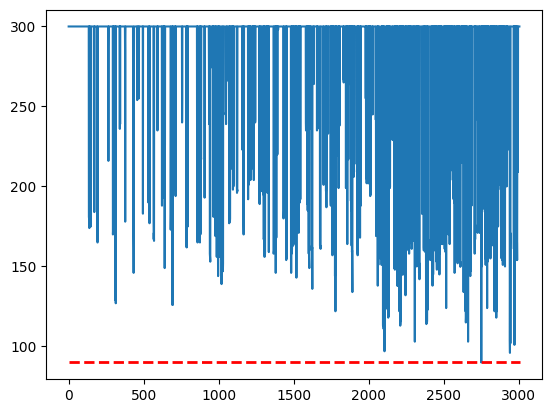

Timesteps over episodes during training

train max rewards =  -125
train means = -290.7747777777778, std = 28.101193083717906
test max rewards =  -84.0
test means = -262.97559622850804, std = 61.260212234482964


In [ ]:
# Initialize empty lists to store training and testing results
train_avg_ts=[]
test_avg_ts=[]

# Set the number of episodes, learning rate, discount factor, and exploration rate
NUM_EPISODES = 6000
TEST_EPISODES = 5
ALPHA_BASE = 0.5
ALPHA = ALPHA_BASE
ALPHA_DECAY_RATE = 0.9
GAMMA = 0.99
EXPLORATION_RATE_BASE = 0.2
EXPLORATION_RATE = EXPLORATION_RATE_BASE
EXPLORATION_RATE_DECAY = 0.95
NUM_DECAY = 10



def mountain_car():
    env = gym.make('MountainCar-v1')
    test_evn = gym.wrappers.Monitor(env, './MountainCar-v1', force=True)
    NUM_ACTIONS = env.action_space.n
    CART_POS = np.linspace(-1.2, 0.6, 10)
    CART_VEL = np.linspace(-0.07, 0.07, 8)
    bins = (CART_POS, CART_VEL)
    # Initialize a QLearning object with the MountainCar-v1 environment and the specified parameters
    qlearning = QLearning(env,
                          bins,
                          num_decay=NUM_DECAY,
                          exploration_rate=EXPLORATION_RATE,
                          exploration_rate_decay=EXPLORATION_RATE_DECAY,
                          alpha=ALPHA,
                          gamma=GAMMA)
    # Set the test interval and train the agent
    test_interval = 10
    train_timesteps = qlearning.train(train_episodes=NUM_EPISODES, test_interval=test_interval)
    # Set the test environment and test the agent
    test_evn = gym.wrappers.Monitor(env, './videos/MountainCar-v1', force=True)
    qlearning.set_env(test_evn)
    test_timesteps = qlearning.test(test_episodes=TEST_EPISODES)
    # Visualize the training results and print the training and testing statistics
    qlearning.visualize('train_mountain.png', train_timesteps, mode='train')
    print('train max rewards = ', np.max(train_rewards))
    print('train means = {}, std = {}'.format(np.mean(train_rewards), np.std(train_rewards)))

    print('test max rewards = ', np.max(test_rewards))
    print('test means = {}, std = {}'.format(np.mean(test_rewards), np.std(test_rewards)))

    # Save the Q-table if the agent performs poorly in the test environment
    if np.mean(test_timesteps) < 100:
        qlearning.save_Qtable('Mountain_Q.pkl')




def main():
    mountain_car()


if __name__ == '__main__':
    main()

#### **Trial 3 observation:**

- The maximum reward achieved during training is -125.
- The average reward during training is -290.77 with a standard deviation of 28.10.
- The maximum reward achieved during testing is -84.
- The average reward during testing is -262.98 with a standard deviation of 61.26.


There are a graphes for testing and training performance at the end of **the last cell run**

### **Determination of the Best Trial:**

Considering both the average rewards and standard deviations during testing, we can determine the best trial as follows:

- Trial 1 has the highest average reward during testing (-231.14) among the three trials, with a relatively higher standard deviation (73.23).
- Trial 2 has a slightly lower average reward during testing (-257.86) compared to Trial 1, but a lower standard deviation (64.78).
- Trial 3 has the lowest average reward during testing (-262.98), but a moderate standard deviation (61.26).
- Based on these observations, Trial 2 demonstrates a relatively better performance with a lower standard deviation during testing. Therefore, considering both the average reward and stability of results, Trial 2 can be considered as the best-performing trial among the three.






**Required 5 (Hyperparemeter search (Tuning))**
  - The requirment was : Apply this requirement ,"If applicable please do an in-depth hyper-parameter search. Report the justification of your choices for each hyper-parameters with supporting plots"
  
  - When we tried to apply it we faced a problem in the resorces needed and need too long time so we can't get a result from it .
  - our trial is in the following part .

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym

from q_learning import QLearning

sns.set()


def run_experiment(num_decay, exploration_rate_base, exploration_rate_decay, alpha_base, alpha_decay_rate, gamma):
    env = gym.make('MountainCar-v0')
    NUM_ACTIONS = env.action_space.n
    CART_POS = np.linspace(-1.2, 0.6, 10)
    CART_VEL = np.linspace(-0.07, 0.07, 8)
    bins = (CART_POS, CART_VEL)

    qlearning = QLearning(env,
                          bins,
                          num_decay=num_decay,
                          exploration_rate=exploration_rate_base,
                          exploration_rate_decay=exploration_rate_decay,
                          alpha=alpha_base,
                          alpha_decay=alpha_decay_rate,
                          gamma=gamma)

    train_timesteps = []
    test_timesteps = []

    for i in range(500):
        train_timesteps.append(qlearning.train(1, test_interval=None))
        test_timesteps.append(qlearning.test(100))

    avg_test_timesteps = np.mean(test_timesteps)
    return avg_test_timesteps


# Define the hyperparameter search space
num_decay_space = list(range(5, 21))
exploration_rate_base_space = np.linspace(0.1, 1, 10)
exploration_rate_decay_space = np.linspace(0.8, 1, 10)
alpha_base_space = np.linspace(0.001, 0.1, 10)
alpha_decay_rate_space = np.linspace(0.8, 1, 10)

# Perform the hyperparameter search
results = np.zeros((len(num_decay_space),
                    len(exploration_rate_base_space),
                    len(exploration_rate_decay_space),
                    len(alpha_base_space),
                    len(alpha_decay_rate_space)))

for i, num_decay in enumerate(num_decay_space):
    for j, exploration_rate_base in enumerate(exploration_rate_base_space):
        for k, exploration_rate_decay in enumerate(exploration_rate_decay_space):
            for l, alpha_base in enumerate(alpha_base_space):
                for m, alpha_decay_rate in enumerate(alpha_decay_rate_space):
                    avg_test_timesteps = run_experiment(num_decay, exploration_rate_base,
                                                         exploration_rate_decay, alpha_base, alpha_decay_rate, 0.99)
                    results[i, j, k, l, m] = avg_test_timesteps
                    print(f"num_decay={num_decay}, exploration_rate_base={exploration_rate_base}, "
                          f"exploration_rate_decay={exploration_rate_decay}, alpha_base={alpha_base}, "
                          f"alpha_decay_rate={alpha_decay_rate}, avg_test_timesteps={avg_test_timesteps}")

# Plot the results
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.heatmap(np.mean(results, axis=(1, 2, 3, 4)), ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f')
axes[0, 0].set_title('Exploration Rate Base vs Num Decay')
axes[0, 0].set_xlabel('Exploration Rate Base')
axes[0, 0].set_ylabel('Num Decay')

sns.heatmap(np.mean(results, axis=(0, 2, 3, 4)), ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f')
axes[0, 1].set_title('Exploration Rate Decay vs Exploration Rate Base')
axes[0, 1].set_xlabel('Exploration Rate Decay')
axes[0, 1].set_ylabel('Exploration Rate Base')

sns.heatmap(np.mean(results, axis=(0, 1, 3, 4)), ax=axes[1, 0], cmap='coolwarm', annot=True, fmt='.2f')
axes[1, 0].set_title('Alpha Decay Rate vs Alpha Base')
axes[1, 0].set_xlabel('Alpha Decay Rate')
axes[1, 0].set_ylabel('Alpha Base')

sns.heatmap(np.mean(results, axis=(0, 1, 2, 3)), ax=axes[1, 1], cmap='coolwarm', annot=True, fmt='.2f')
axes[1, 1].set_title('Exploration Rate Decay vs Alpha Decay Rate')
axes[1, 1].set_xlabel('Exploration Rate Decay')
axes[1, 1].set_ylabel('Alpha Decay Rate')

plt.tight_layout()
plt.show()